In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Preprocessing

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

dataset_path = './leafsnap-dataset/dataset/'

# List the folders and files in the dataset directory
folder_structure = os.listdir(dataset_path)
folder_structure


Using device: cpu


['images', 'segmented']

In [22]:
data_info_path = './leafsnap-dataset-images.txt'
data_info = pd.read_csv(data_info_path, sep='\t')

# Count the number of images per species
class_counts = data_info['species'].value_counts()


print(class_counts)

# Check if classes are balanced
print("\nClass Balance Check:")
print(f"Max: {class_counts.max()}, Min: {class_counts.min()}, Total Classes: {len(class_counts)}")

num_classes = len(class_counts)

print("NumClasses:", num_classes)


species
Maclura pomifera            448
Ulmus rubra                 317
Prunus virginiana           303
Acer rubrum                 297
Broussonettia papyrifera    294
                           ... 
Styrax obassia               79
Quercus rubra                71
Toona sinensis               64
Quercus falcata              60
Magnolia soulangiana         56
Name: count, Length: 185, dtype: int64

Class Balance Check:
Max: 448, Min: 56, Total Classes: 185
NumClasses: 185


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the full dataset
full_dataset = datasets.ImageFolder(root=f'{dataset_path}/images')

# training (70%), and remaining 30% for validation + test
train_idx, val_test_idx = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42)

val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

# Create subsets for training, validation, and test
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val_test']
test_dataset.dataset.transform = data_transforms['val_test']

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}, Test images: {len(test_dataset)}")
train_images, train_labels = next(iter(train_loader))
print(f"Train batch shape: {train_images.shape}, Train Labels: {train_labels}")


Training images: 21606, Validation images: 4630, Test images: 4630
Train batch shape: torch.Size([32, 3, 224, 224]), Train Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0])


### Training

In [5]:
# Load the ResNet18 model with updated weights argument
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 185)

model = model.to(device)

print("Model is set up and moved to device.")


Model is set up and moved to device.


In [6]:
# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (only updating the final layer)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("Loss function and optimizer are set.")


Loss function and optimizer are set.


In [7]:
# Subset to 20% of the dataset
train_size = int(0.2 * len(train_dataset))
val_size = int(0.2 * len(val_dataset))

# 10% training and validation sets
train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
val_subset, _ = random_split(val_dataset, [val_size, len(val_dataset) - val_size])

# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

In [10]:
# Inicializar listas 
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []

best_val_acc = 0.0
best_model_wts = model.state_dict()

# Training loop for 10 epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss, running_corrects, running_preds, running_labels = 0.0, 0, [], []
    print(f"Epoch {epoch+1}/{epochs}")

    for inputs, labels in tqdm(train_loader, desc="Training Progress"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        # Track performance
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_preds.extend(preds.cpu().numpy())
        running_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    epoch_f1 = f1_score(running_labels, running_preds, average='weighted')

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    train_f1s.append(epoch_f1)

    model.eval()
    val_loss, val_corrects, val_preds, val_labels = 0.0, 0, [], []
    
   
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation Progress"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Track validation performance
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / val_size
    val_acc = val_corrects.double() / val_size
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Train F1: {epoch_f1:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()


torch.save(best_model_wts, 'resnet18_model_best.pth')
print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

Epoch 1/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [01:52<00:00,  3.89s/it]


Epoch 1/10, Train Loss: 0.0194, Train Acc: 0.9947, Train F1: 0.9947
Validation Loss: 0.0150, Val Acc: 0.9989, Val F1: 0.9989
Epoch 2/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [01:45<00:00,  3.62s/it]


Epoch 2/10, Train Loss: 0.0383, Train Acc: 0.9863, Train F1: 0.9864
Validation Loss: 0.0114, Val Acc: 0.9968, Val F1: 0.9968
Epoch 3/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [01:50<00:00,  3.81s/it]


Epoch 3/10, Train Loss: 0.0136, Train Acc: 0.9968, Train F1: 0.9968
Validation Loss: 0.0114, Val Acc: 0.9968, Val F1: 0.9968
Epoch 4/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [02:01<00:00,  4.19s/it]


Epoch 4/10, Train Loss: 0.0159, Train Acc: 0.9961, Train F1: 0.9961
Validation Loss: 0.0100, Val Acc: 0.9989, Val F1: 0.9989
Epoch 5/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [01:48<00:00,  3.74s/it]


Epoch 5/10, Train Loss: 0.0431, Train Acc: 0.9847, Train F1: 0.9848
Validation Loss: 0.0103, Val Acc: 0.9968, Val F1: 0.9968
Epoch 6/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [00:54<00:00,  1.89s/it]


Epoch 6/10, Train Loss: 0.0135, Train Acc: 0.9963, Train F1: 0.9963
Validation Loss: 0.0088, Val Acc: 0.9978, Val F1: 0.9978
Epoch 7/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [00:51<00:00,  1.77s/it]


Epoch 7/10, Train Loss: 0.0136, Train Acc: 0.9956, Train F1: 0.9956
Validation Loss: 0.0104, Val Acc: 0.9978, Val F1: 0.9978
Epoch 8/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [00:54<00:00,  1.87s/it]


Epoch 8/10, Train Loss: 0.0112, Train Acc: 0.9984, Train F1: 0.9984
Validation Loss: 0.0092, Val Acc: 0.9989, Val F1: 0.9989
Epoch 9/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [00:54<00:00,  1.88s/it]


Epoch 9/10, Train Loss: 0.0123, Train Acc: 0.9979, Train F1: 0.9979
Validation Loss: 0.0099, Val Acc: 0.9978, Val F1: 0.9978
Epoch 10/10


Validation Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [00:55<00:00,  1.90s/it]

Epoch 10/10, Train Loss: 0.0232, Train Acc: 0.9919, Train F1: 0.9919
Validation Loss: 0.0091, Val Acc: 0.9968, Val F1: 0.9968
Best model saved with validation accuracy: 0.9989


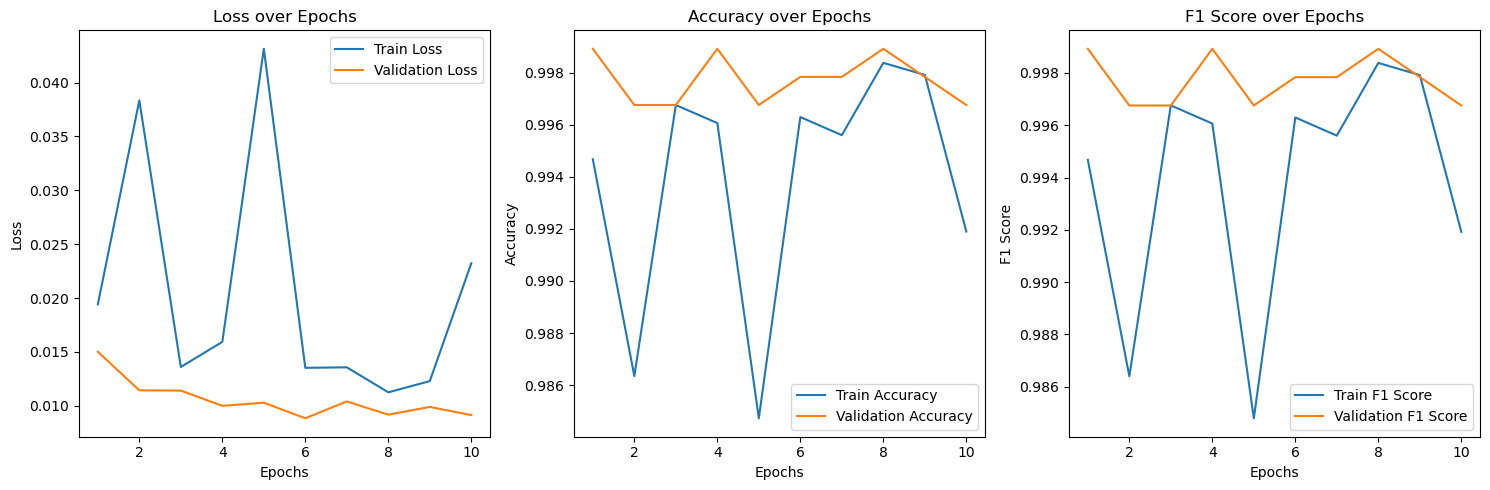

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, train_f1s, label='Train F1 Score')
    plt.plot(epochs_range, val_f1s, label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s)


# Random Test with 1 image

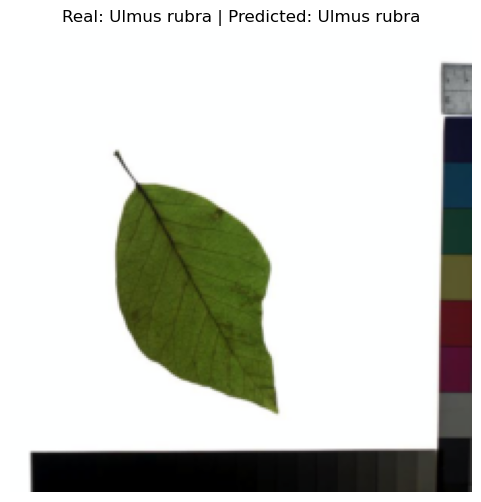

In [26]:
# to re- run this part you may have to run the imports and the preprocessing part

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# class names from species in data_info
class_counts = data_info['species'].value_counts()
class_names = class_counts.index.tolist()
num_classes = len(class_names)

# Load the model and adjust the final layer
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('resnet18_model_best.pth', map_location=device))
model.to(device)
model.eval()

# Select a random test image from the Subset
random_idx = random.randint(0, len(test_dataset) - 1)
test_img, test_label = test_dataset[random_idx]

input_img = test_img.unsqueeze(0).to(device)

# Make the prediction
with torch.no_grad():
    outputs = model(input_img)
    _, predicted_label = torch.max(outputs, 1)

# real and predicted class names
real_class = class_names[test_label]
predicted_class = class_names[predicted_label.item()]

plt.figure(figsize=(6, 6))
imshow(test_img, title=f"Real: {real_class} | Predicted: {predicted_class}")
plt.show()


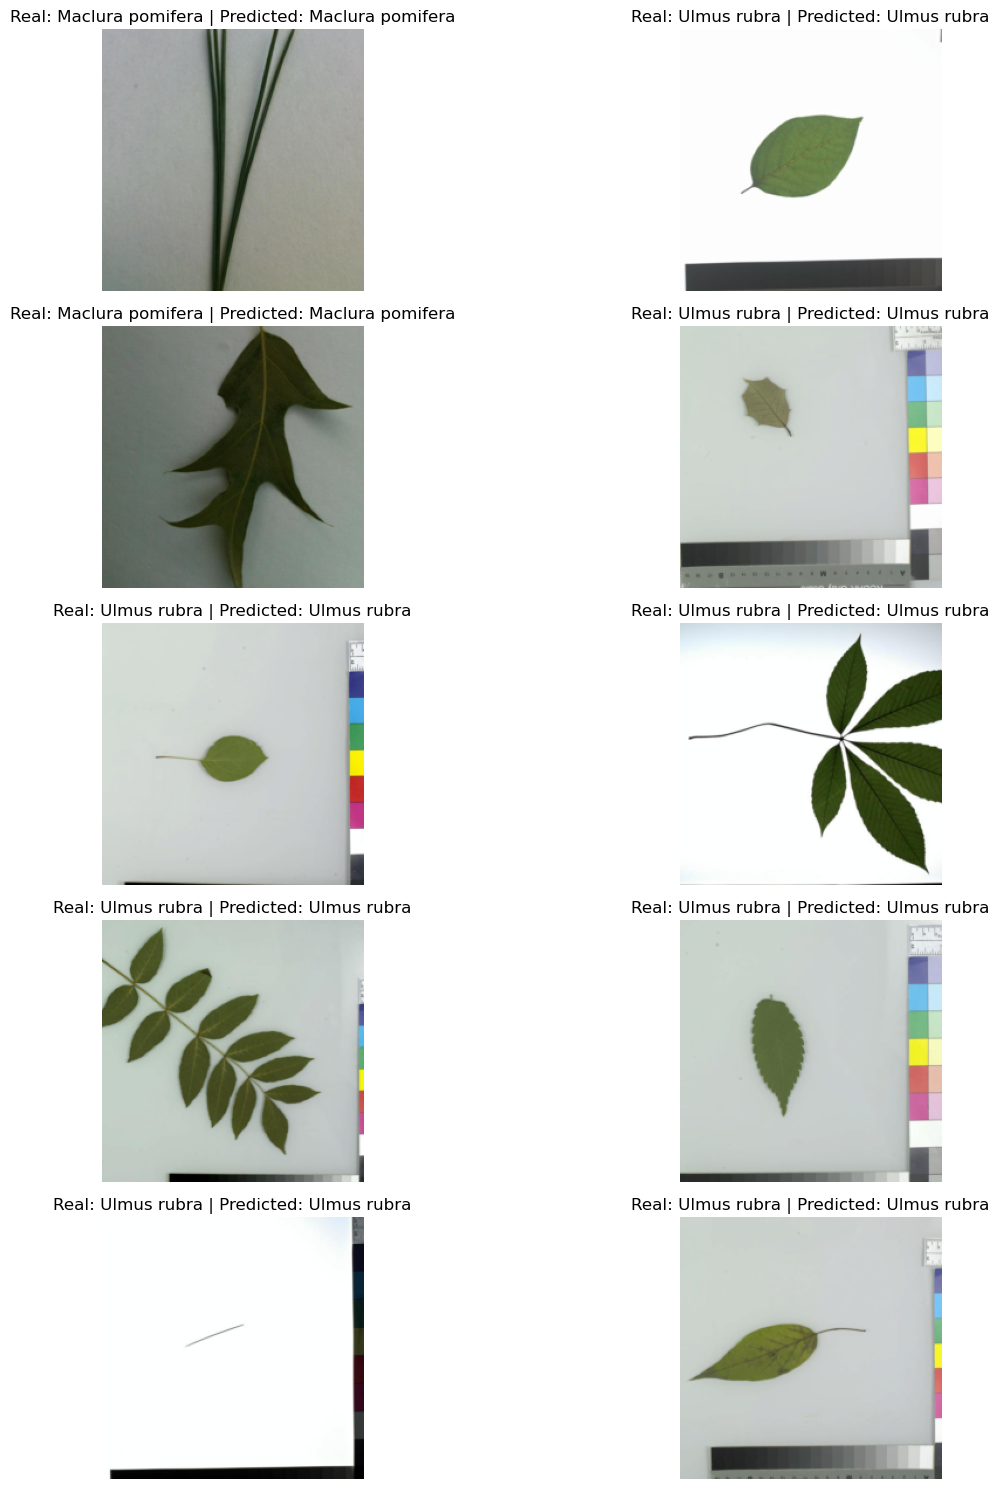

In [27]:
random_indices = random.sample(range(len(test_dataset)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    test_img, test_label = test_dataset[idx]
    input_img = test_img.unsqueeze(0).to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = model(input_img)
        _, predicted_label = torch.max(outputs, 1)

    # Get real and predicted class names
    real_class = class_names[test_label]
    predicted_class = class_names[predicted_label.item()]

    # Display the image with real and predicted labels
    plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns for 10 images
    imshow(test_img, title=f"Real: {real_class} | Predicted: {predicted_class}")

plt.tight_layout()
plt.show()